<a href="https://colab.research.google.com/github/Justin-Tan/high-fidelity-generative-compression/blob/hific_demo/assets/HiFIC_torch_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HiFIC Demo
Compress arbitrary images in Colab using a pretrained neural compression model - see the [Github repo](https://github.com/Justin-Tan/high-fidelity-generative-compression) for the source.


## Setup Colab Environment

In [ ]:
import torch
import numpy as np

import os
import glob
import urllib
import zipfile
import collections

from google.colab import files
from PIL import Image
from IPython.display import Image as DisplayImage
from IPython.display import Javascript
from IPython.core.display import display, HTML

INPUT_DIR = '/content/files'
STAGING_DIR = '/content/stage'
OUT_DIR = '/content/out'
CKPT_DIR = '/content/checkpoint'
DEFAULT_IMAGE_URL = ('https://storage.googleapis.com/hific/clic2020/'
                     'images/originals/ad249bba099568403dc6b97bc37f8d74.png')

File = collections.namedtuple('File', ['output_path', 'compressed_path',
                                       'num_bytes', 'bpp'])
_ = [os.makedirs(dir, exist_ok=True) for dir in (INPUT_DIR, STAGING_DIR, OUT_DIR,
                                                 CKPT_DIR)]

In [ ]:
def print_html(html):
    display(HTML(html + '<br/>'))

def make_cell_large():
    display(Javascript(
        '''google.colab.output.setIframeHeight(0, true, {maxHeight: 5192})'''))

def get_default_image(output_dir):
    output_path = os.path.join(output_dir, os.path.basename(DEFAULT_IMAGE_URL))
    print('Downloading', DEFAULT_IMAGE_URL, '\n->', output_path)
    urllib.request.urlretrieve(DEFAULT_IMAGE_URL, output_path)

def get_model_checkpoint(output_dir, model_ID, model_choice):
    output_path = os.path.join(output_dir, f'{model_choice.lower()}.pt')
    if os.path.exists(output_path):
        print('File already exists at', '\n->', output_path)
        return output_path
    else:
        print('Downloading model to', '\n->', output_path)
        !wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$model_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$model_ID" -O $output_path && rm -rf /tmp/cookies.txt
    return output_path

## Select Model
Higher bitrates result in higher-fidelity reconstructions, at the expense of increased message length.

In [ ]:
# Enter choice to right
model_choice = 'HIFIC-high' #@param ["HIFIC-low", "HIFIC-med", "HIFIC-high"]


Clone repo and grab the model checkpoint (around 2 GB).

In [ ]:
# Drive IDs
model_choices = {'HIFIC-low': '1hfFTkZbs_VOBmXQ-M4bYEPejrD76lAY9',
                 'HIFIC-med': '1QNoX0AGKTBkthMJGPfQI0dT0_tnysYUb',
                 'HIFIC-high': '1BFYpvhVIA_Ek2QsHBbKnaBE8wn1GhFyA'}

model_ID = model_choices[model_choice]
model_path = get_model_checkpoint(CKPT_DIR, model_ID, model_choice)

-> /content/checkpoint/hific-high.pt
/content/checkpoint     [     <=>            ]   2.06G  69.6MB/s    in 33s     


In [ ]:
# !git clone -b hific_demo https://github.com/Justin-Tan/high-fidelity-generative-compression.git
%cd high-fidelity-generative-compression/

/content/high-fidelity-generative-compression/high-fidelity-generative-compression


## Prepare Images

To upload your own images (JPG or PNG without alpha channels), set `custom_image=True` in the following cell. Otherwise, we'll use a default image from the CLIC2020 Compression Challenge dataset.

Alternatively, you can use the `Files` tab on the left and select the `Upload to session storage` icon to upload more custom images.

In [ ]:
custom_image = False #@param ["False", "True"] {type:"raw"}

Using default image.
-> /content/files/ad249bba099568403dc6b97bc37f8d74.png
Got following files (1):
-> ad249bba099568403dc6b97bc37f8d74.png:


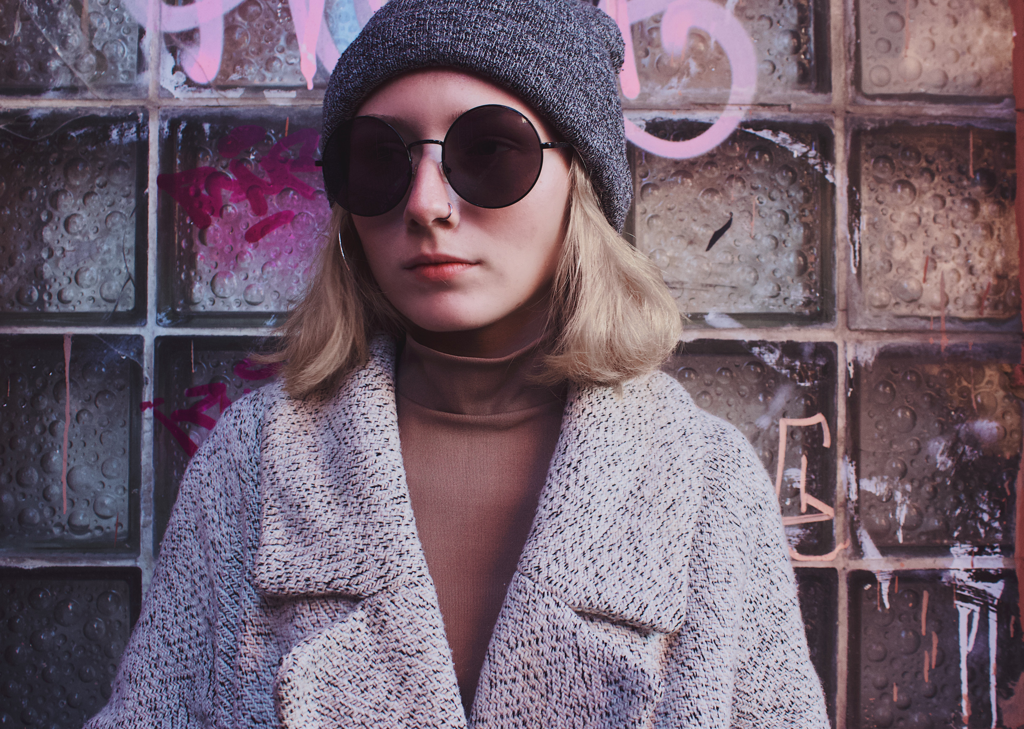

In [ ]:


if custom_image is True:
    print('Using user-defined images.')
    # Get dict of upload files
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
        !mv -iv $fn $INPUT_DIR
else:
    print('Using default image.')
    # Download default image
    get_default_image(INPUT_DIR)

all_files = os.listdir(INPUT_DIR)
print(f'Got following files ({len(all_files)}):')
scale_factor = 2 if len(all_files) == 1 else 4
for file_name in all_files:
    img = Image.open(os.path.join(INPUT_DIR, file_name))
    w, h = img.size
    img = img.resize((w // scale_factor, h // scale_factor))
    print('-> ' + file_name + ':')
    display(img)

In [ ]:
SUPPORTED_EXT = {'.png', '.jpg'}

all_files = os.listdir(INPUT_DIR)
if not all_files:
    raise ValueError("Please upload images!")

def get_bpp(image_dimensions, num_bytes):
    w, h = image_dimensions
    return num_bytes * 8 / (w * h)

def has_alpha(img_p):
    im = Image.open(img_p)
    return im.mode == 'RGBA'

for file_name in all_files:
    if os.path.isdir(file_name):
        continue
    if not any(file_name.endswith(ext) for ext in SUPPORTED_EXT):
        print('Skipping non-image', file_name, '...')
        continue
    full_path = os.path.join(INPUT_DIR, file_name)
    if has_alpha(full_path) is True:
        print('Skipping because of alpha channel:', file_name)
        continue
    file_name, _ = os.path.splitext(file_name)
    output_path = os.path.join(OUT_DIR, f'{file_name}.png')
    !mv -v $full_path $STAGING_DIR

renamed '/content/files/ad249bba099568403dc6b97bc37f8d74.png' -> '/content/stage/ad249bba099568403dc6b97bc37f8d74.png'


## Enabling GPU

GPU should be enabled for this Colab. If the next cell prints a warning, do the following:
- Navigate to `Edit →> Notebook Settings`
- Select GPU from the Hardware Accelerator drop-down


In [ ]:
if torch.cuda.is_available() is False:
  print('WARNING: No GPU found. Compression/decompression will be slow!')
else:
  print(f'Found GPU {torch.cuda.get_device_name(0)}')

Found GPU Tesla K80


# Compress Images
Note: Models can take up to 3 minutes to load on Colab, depending on the allocated GPU and chosen model.



In [ ]:
from compress import prepare_compress, compress_and_save, load_and_decompress, compress_and_decompress
# Setup model
print('Building model ...')
model, args, data_loader = prepare_compress(model_path, STAGING_DIR, OUT_DIR)

17:25:58 INFO - logger_setup: /content/high-fidelity-generative-compression/compress.py
17:25:58 INFO - logger_setup: /content/high-fidelity-generative-compression/compress.py


Building model ...
Input images
['/content/stage/ad249bba099568403dc6b97bc37f8d74.png']
Setting up Perceptual loss...


17:26:30 INFO - load_model: Loading model ...
17:26:30 INFO - load_model: Loading model ...
17:26:30 INFO - load_model: Estimated model size (under fp32): 725.903 MB
17:26:30 INFO - load_model: Estimated model size (under fp32): 725.903 MB
17:26:30 INFO - load_model: Model init 31.889s
17:26:30 INFO - load_model: Model init 31.889s


Loading model from: /content/high-fidelity-generative-compression/src/loss/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done
Loaded model
Building PT


Encode images and save compressed format to disk

In [ ]:
%%time
compress_and_save(model, args, data_loader, OUT_DIR)

  0%|          | 0/1 [00:00<?, ?it/s]17:26:50 INFO - compress: [ESTIMATED]
17:26:50 INFO - compress: [ESTIMATED]
17:26:50 INFO - compress: BPP: 0.482
17:26:50 INFO - compress: BPP: 0.482
17:26:50 INFO - compress: HL BPP: 0.024
17:26:50 INFO - compress: HL BPP: 0.024
17:26:50 INFO - compress: L BPP: 0.458
17:26:50 INFO - compress: L BPP: 0.458
17:26:50 INFO - compress: [ATTAINED]
17:26:50 INFO - compress: [ATTAINED]
17:26:50 INFO - compress: BPP: 0.495
17:26:50 INFO - compress: BPP: 0.495
17:26:50 INFO - compress: HL BPP: 0.030
17:26:50 INFO - compress: HL BPP: 0.030
17:26:50 INFO - compress: L BPP: 0.465
17:26:50 INFO - compress: L BPP: 0.465
17:26:50 INFO - compress_and_save: Attained: 0.062 bpp vs. theoretical: 0.482 bpp.
17:26:50 INFO - compress_and_save: Attained: 0.062 bpp vs. theoretical: 0.482 bpp.
100%|██████████| 1/1 [00:11<00:00, 11.98s/it]

CPU times: user 10.4 s, sys: 1.09 s, total: 11.5 s
Wall time: 12 s


Load compressed format from disk and decode

In [ ]:
all_outputs = []

for compressed_file in glob.glob(os.path.join(OUT_DIR, '*.hfc')):
    file_name, _ = os.path.splitext(compressed_file)
    output_path = os.path.join(OUT_DIR, f'{file_name}.png')

    # Model decode
    load_and_decompress(model, compressed_file, output_path)
    
    all_outputs.append(File(output_path=output_path,
                            compressed_path=compressed_file,
                            num_bytes=os.path.getsize(compressed_file),
                            bpp=get_bpp(Image.open(output_path).size, os.path.getsize(compressed_file))))

17:27:22 INFO - load_and_decompress: Decoding time: 32.20 s
17:27:22 INFO - load_and_decompress: Decoding time: 32.20 s
17:27:22 INFO - load_and_decompress: Reconstruction saved to /content/out/ad249bba099568403dc6b97bc37f8d74_compressed.png
17:27:22 INFO - load_and_decompress: Reconstruction saved to /content/out/ad249bba099568403dc6b97bc37f8d74_compressed.png


# Show output

<IPython.core.display.Javascript object>

Showing /content/out/ad249bba099568403dc6b97bc37f8d74_compressed.png | 184 kB | 0.4952 bpp


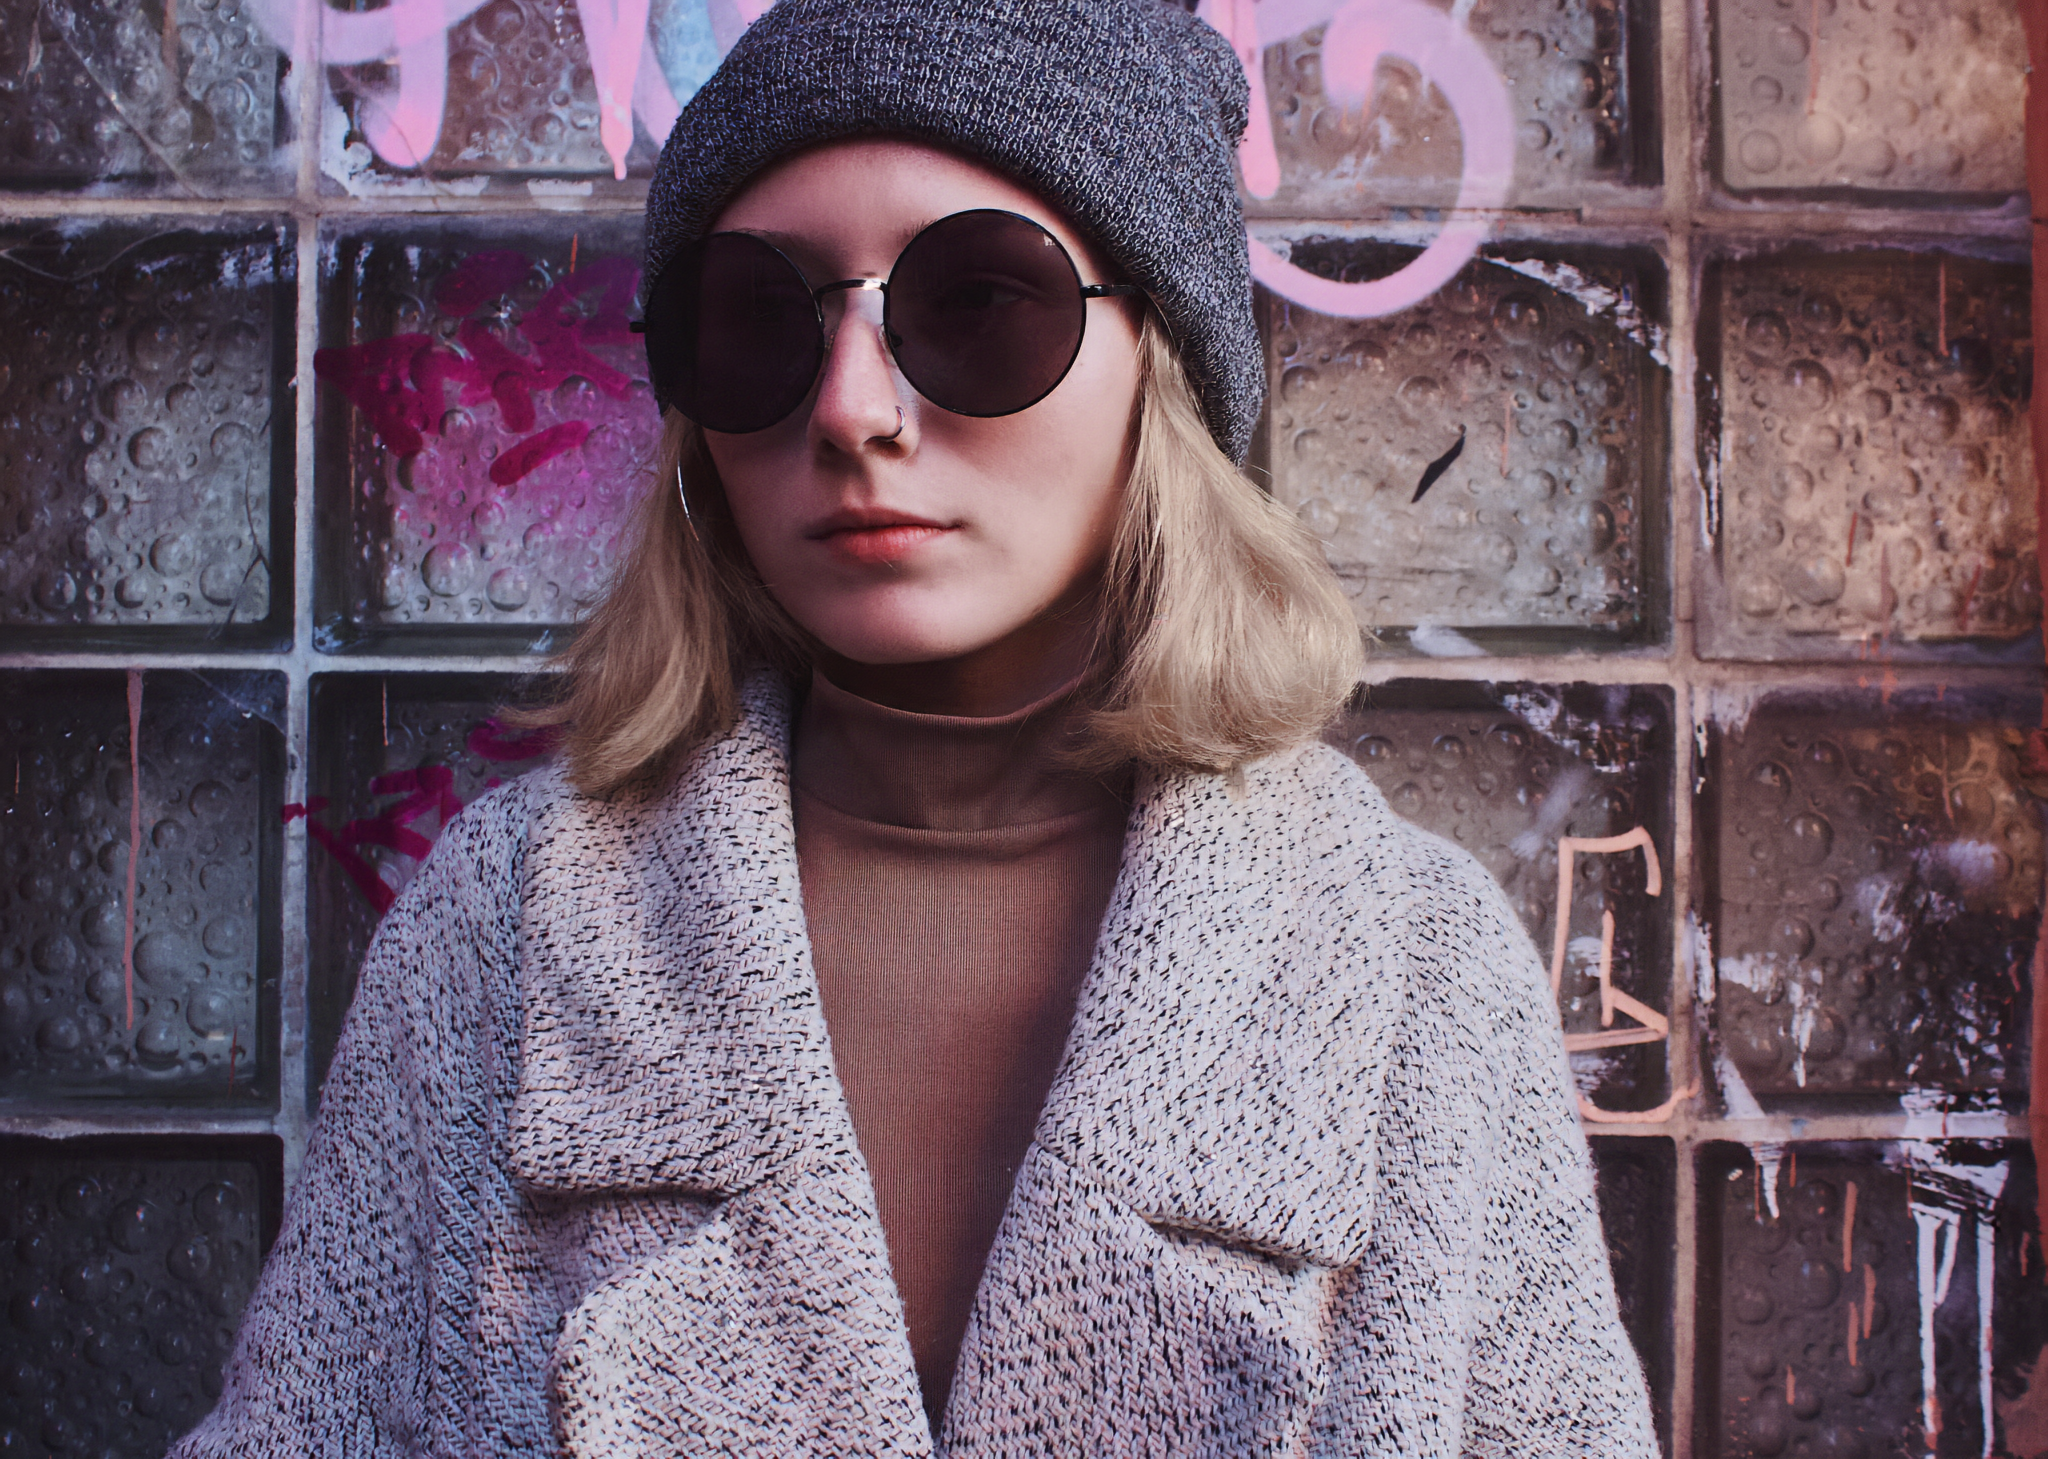

In [ ]:
make_cell_large()  # Larger output window.

for file in all_outputs:
    print_html('<hr/>')
    print(f'Showing {file.output_path} | {file.num_bytes//1000} kB | {file.bpp:.4f} bpp')
    display(Image.open(file.output_path))
    print_html('<hr/>')

### Download compressed images

Note: Files are losslessly saved as PNG for viewing.


In [ ]:
download_outputs = False #@param ["False", "True"] {type:"raw"}

In [ ]:
if download_outputs is True:
    ZIP = '/content/hific_compressed_images.zip'

    with zipfile.ZipFile(ZIP, 'w') as zf:
        for f in all_outputs:
            path_with_bpp = f.output_path.replace('.png', f'-{f.bpp:.3f}bpp.png')
            zf.write(f.output_path, os.path.basename(path_with_bpp))

    files.download(ZIP) 

# Citation

This is an implementation of the orignal paper. Please cite the [original paper](https://arxiv.org/abs/2006.09965) if you use their work.

```bash
@article{mentzer2020high,
  title={High-Fidelity Generative Image Compression},
  author={Mentzer, Fabian and Toderici, George and Tschannen, Michael and Agustsson, Eirikur},
  journal={arXiv preprint arXiv:2006.09965},
  year={2020}
}
```